In [ ]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

In [ ]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Q1)

The model is a **CLIP** model, consisting of two main components: a **text encoder** and a **vision encoder**.

1. **Text Encoder:**
   - Architecture: **Transformer-based**
   - Purpose: Encodes input text into a fixed-size feature vector.
   - Input: Tokenized text sequence with positional embeddings.
   - Output: 512-dimensional text embeddings.

2. **Vision Encoder:**
   - Architecture: **Vision Transformer (ViT)**.
   - Purpose: Encodes input images into a fixed-size feature vector.
   - Input: Image patches with positional embeddings.
   - Output: 512-dimensional image embeddings.

3. **Projection Heads:**
   - Both the text and vision embeddings are projected to a common 512-dimensional latent space to compute contrastive similarity.



#### Text Encoder Architecture
1. **Embedding Layer:**
   - **Token Embedding:** Maps 49,408 tokens to 512-dimensional vectors.
     - **Parameters:** \( 49408 * 512 = 25,311,232 \).
   - **Position Embedding:** Embeds the position of up to 77 tokens.
     - **Parameters:** \( 77 * 512 = 39,424 \).

2. **Transformer Encoder:**
   - **Number of Layers:** 12.
   - Each layer contains:
     - **Self-Attention Mechanism (CLIPSdpaAttention):**
       - **K, Q, V Projections:** Linear transformations from 512 to 512 dimensions.
         - **Parameters per projection:** \( 512 * 512 + 512 = 262,656 \) (bias included).
         - Total for K, Q, V, and output projection: \( 4 * 262,656 = 1,050,624 \).
     - **Layer Norm:** Maintains stability and speeds up training.
         - **Parameters:** \( 512 * 2 = 1,024 \) (scaling and bias).
     - **MLP Block:**
       - **First Linear Layer:** Expands features from 512 to 2048 dimensions.
         - **Parameters:** \( 512 * 2048 + 2048 = 1,050,624 \).
       - **Second Linear Layer:** Reduces features from 2048 to 512 dimensions.
         - **Parameters:** \( 2048 * 512 + 512 = 1,050,624 \).

   - **Total Parameters per Transformer Layer:**
     \( 1,050,624 + 1,024 + 2,101,248 = 3,152,896 \).
   - **Total Transformer Parameters:** \( 3,152,896 * 12 = 37,834,752 \).

3. **Final Layer Norm:**
   - Parameters: \( 512 * 2 = 1,024 \).


#### Vision Encoder Architecture
1. **Embedding Layer:**
   - **Patch Embedding:** Converts input image (split into patches) into feature vectors using a convolutional layer.
     - Input Channels: 3 (RGB).
     - Output Channels: 768.
     - Kernel Size: \( 32 * 32 \).
     - **Parameters:** \( 3 * 32 * 32 * 768 = 2,359,296 \).
   - **Position Embedding:** Embeds positions for up to 50 patches.
     - **Parameters:** \( 50 * 768 = 38,400 \).

2. **Transformer Encoder:**
   - **Number of Layers:** 12.
   - Each layer contains:
     - **Self-Attention Mechanism (CLIPSdpaAttention):**
       - **K, Q, V Projections:** Linear transformations from 768 to 768 dimensions.
         - **Parameters per projection:** \( 768 * 768 + 768 = 590,592 \).
         - Total for K, Q, V, and output projection: \( 4 * 590,592 = 2,362,368 \).
     - **Layer Norm:** Parameters: \( 768 * 2 = 1,536 \).
     - **MLP Block:**
       - **First Linear Layer:** Expands features from 768 to 3072 dimensions.
         - **Parameters:** \( 768 * 3072 + 3072 = 2,362,368 \).
       - **Second Linear Layer:** Reduces features from 3072 to 768 dimensions.
         - **Parameters:** \( 3072 * 768 + 768 = 2,362,368 \).

   - **Total Parameters per Transformer Layer:**
     \( 2,362,368 + 1,536 + 4,724,736 = 7,088,640 \).
   - **Total Transformer Parameters:** \( 7,088,640 * 12 = 85,063,680 \).

3. **Final Layer Norm:**
   - Parameters: \( 768 * 2 = 1,536 \).


#### Projection Heads
1. **Text Projection:**
   - Maps 512-dimensional text embeddings to the shared 512-dimensional space.
     - **Parameters:** \( 512 * 512 = 262,144 \).

2. **Vision Projection:**
   - Maps 768-dimensional vision embeddings to the shared 512-dimensional space.
     - **Parameters:** \( 768 * 512 = 393,216 \).


#### Parameter Breakdown
1. **Text Model Total:** ~63.1M parameters.
2. **Vision Model Total:** ~87.9M parameters.
3. **Projection Layers Total:** ~0.65M parameters.
4. **Grand Total:** ~151.7M parameters.



### Summary
This CLIP model uses a **transformer architecture** for both text and vision encoders. It leverages **self-attention mechanisms** to encode textual and visual data into feature vectors, and the projection layers align these features into a shared latent space for contrastive learning. Key architectural components include:
- **Self-Attention Layers (K, Q, V projections):** Capture relationships between tokens or image patches.
- **MLP Layers:** Expand and compress features for non-linear transformations.
- **Embedding Layers:** Encode input text tokens and image patches.

This architecture allows the model to learn a joint representation of text and images for tasks like image-text retrieval or zero-shot classification.


In [ ]:
print(model)

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [ ]:
os.getcwd()

'/content'

In [ ]:
os.listdir()

['.config', 'sample_data']

In [ ]:
!unrar x /content/datah4.rar /content/extracted/


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/datah4.rar

Creating    /content/extracted                                        OK
Creating    /content/extracted/datah4                                 OK
Creating    /content/extracted/datah4/blurred                         OK
Extracting  /content/extracted/datah4/blurred/AirplaneSide_V1.jpg          0%  OK 
Extracting  /content/extracted/datah4/blurred/AirplaneSide_V2.jpg          0%  OK 
Extracting  /content/extracted/datah4/blurred/Airplaneside_V3.jpg          0%  OK 
Extracting  /content/extracted/datah4/blurred/airplaneThree-Quarter_v3.jpg       1%  OK 
Extracting  /content/extracted/datah4/blurred/AirplaneThreeQuarter_V1.jpg       1%  OK 
Extracting  /content/extracted/datah4/blurred/airplanethreequarter_V4.jpg       1%  OK 
Extracting  /content/extracted/datah4/blurred/carside-v1.jpg               2%  OK 
Extracti

In [ ]:
extracted_path = '/content/extracted'
print(os.listdir(extracted_path))

['datah4']


In [ ]:
datah4_path = os.path.join(extracted_path, 'datah4')
img_cat=os.listdir(datah4_path)
print("Content:", os.listdir(datah4_path))

Content: ['blurred', 'silhouettes', 'realistic', 'geons', 'features']


In [ ]:
img_cat

['blurred', 'silhouettes', 'realistic', 'geons', 'features']

In [ ]:
extracted_path = '/content/extracted/datah4'
image_types = ["chair", "hat", "car", "duck", "airplane", "donkey", "dog", "cup"]

image_df = pd.DataFrame()
image_list = []

for cat in img_cat:
  path = os.path.join(extracted_path, cat)
  files = os.listdir(path)
  files = [os.path.join(path, fil) for fil in files]
  image_list.extend(files)

print(len(image_list))

225


In [ ]:
image_df['Images'] = image_list
image_df.head()

,Images
0,/content/extracted/datah4/blurred/Airplaneside...
1,/content/extracted/datah4/blurred/HatThreequar...
2,/content/extracted/datah4/blurred/Duckside_V3.jpg
3,/content/extracted/datah4/blurred/DuckThreeQua...
4,/content/extracted/datah4/blurred/Duckside-V2.jpg


In [ ]:
per_image_cat = []
for im in image_df["Images"]:
  for cat in img_cat:
    if cat in im.lower():
      per_image_cat.append(cat)
      break

image_df['Image_Category'] = per_image_cat

In [ ]:
per_image_type = []
for im in image_df["Images"]:
  for typ in image_types:
    if typ in im.lower():
      per_image_type.append(typ)
      break

image_df['Image_Type'] = per_image_type

In [ ]:
image_types = ["chair", "hat", "car", "duck", "airplane", "donkey", "dog", "cup"]
image_labels = []
for im in image_df['Image_Type']:
  im_lbl = []
  for image_typ in image_types:
    if im == image_typ:
      im_lbl.append(1)
    else:
      im_lbl.append(0)
  image_labels.append(im_lbl)

image_df['Image_Label'] = image_labels

In [ ]:
statements = []
for i in range(len(image_df['Image_Type'])):
  im_st = []
  for image_typ in image_types:
    im_st.append(f"a photo of {image_typ}")
  statements.append(im_st)

image_df["Statements"] = statements

In [ ]:
prediction_probas = []

for im, st in zip(image_df["Images"], image_df["Statements"]):
  image = Image.open(im)

  inputs = processor(text=st, images=image, return_tensors="pt", padding=True)

  outputs = model(**inputs)
  logits_per_image = outputs.logits_per_image
  probs = logits_per_image.softmax(dim=1)

  prediction_probas.append(probs.detach().numpy().tolist())

  del inputs
  del outputs
  del logits_per_image
  del probs
  del image

image_df["Prediction_Probabilities"] = prediction_probas

Getting the Predication Probablities for each category along with Correct Predication

In [ ]:
image_df

,Images,Image_Category,Image_Type,Image_Label,Statements,Prediction_Probabilities
0,/content/extracted/datah4/blurred/Airplaneside...,blurred,airplane,"[0, 0, 0, 0, 1, 0, 0, 0]","[a photo of chair, a photo of hat, a photo of ...","[[0.05592680349946022, 0.07563173025846481, 0...."
1,/content/extracted/datah4/blurred/HatThreequar...,blurred,hat,"[0, 1, 0, 0, 0, 0, 0, 0]","[a photo of chair, a photo of hat, a photo of ...","[[0.021020298823714256, 0.8762422800064087, 0...."
2,/content/extracted/datah4/blurred/Duckside_V3.jpg,blurred,duck,"[0, 0, 0, 1, 0, 0, 0, 0]","[a photo of chair, a photo of hat, a photo of ...","[[0.0004674981173593551, 0.004587771371006966,..."
3,/content/extracted/datah4/blurred/DuckThreeQua...,blurred,duck,"[0, 0, 0, 1, 0, 0, 0, 0]","[a photo of chair, a photo of hat, a photo of ...","[[0.03609943017363548, 0.08240184932947159, 0...."
4,/content/extracted/datah4/blurred/Duckside-V2.jpg,blurred,duck,"[0, 0, 0, 1, 0, 0, 0, 0]","[a photo of chair, a photo of hat, a photo of ...","[[0.0038139938842505217, 0.03755037114024162, ..."
...,...,...,...,...,...,...
220,/content/extracted/datah4/features/DuckSide_V4...,features,duck,"[0, 0, 0, 1, 0, 0, 0, 0]","[a photo of chair, a photo of hat, a photo of ...","[[0.015315128490328789, 0.4785444140434265, 0...."
221,/content/extracted/datah4/features/DogThreequa...,features,dog,"[0, 0, 0, 0, 0, 0, 1, 0]","[a photo of chair, a photo of hat, a photo of ...","[[0.0013247966999188066, 0.009093232452869415,..."
222,/content/extracted/datah4/features/ChairThreeQ...,features,chair,"[1, 0, 0, 0, 0, 0, 0, 0]","[a photo of chair, a photo of hat, a photo of ...","[[0.9993946552276611, 0.0002335271710762754, 1..."
223,/content/extracted/datah4/features/DuckThreeQu...,features,duck,"[0, 0, 0, 1, 0, 0, 0, 0]","[a photo of chair, a photo of hat, a photo of ...","[[0.0011400396469980478, 0.005847575142979622,..."


In [ ]:
prediction_accuracy = []

for lbl, preds in zip(image_df['Image_Label'], image_df['Prediction_Probabilities']):
    preds = preds[0]
    max_idx1 = lbl.index(max(lbl))
    max_idx2 = preds.index(max(preds))
    prediction_accuracy.append(int(max_idx1 == max_idx2))

image_df['Correct_Prediction'] = prediction_accuracy

In [ ]:
image_df

,Images,Image_Category,Image_Type,Image_Label,Statements,Prediction_Probabilities,Correct_Prediction
0,/content/extracted/datah4/blurred/Airplaneside...,blurred,airplane,"[0, 0, 0, 0, 1, 0, 0, 0]","[a photo of chair, a photo of hat, a photo of ...","[[0.05592680349946022, 0.07563173025846481, 0....",1
1,/content/extracted/datah4/blurred/HatThreequar...,blurred,hat,"[0, 1, 0, 0, 0, 0, 0, 0]","[a photo of chair, a photo of hat, a photo of ...","[[0.021020298823714256, 0.8762422800064087, 0....",1
2,/content/extracted/datah4/blurred/Duckside_V3.jpg,blurred,duck,"[0, 0, 0, 1, 0, 0, 0, 0]","[a photo of chair, a photo of hat, a photo of ...","[[0.0004674981173593551, 0.004587771371006966,...",1
3,/content/extracted/datah4/blurred/DuckThreeQua...,blurred,duck,"[0, 0, 0, 1, 0, 0, 0, 0]","[a photo of chair, a photo of hat, a photo of ...","[[0.03609943017363548, 0.08240184932947159, 0....",1
4,/content/extracted/datah4/blurred/Duckside-V2.jpg,blurred,duck,"[0, 0, 0, 1, 0, 0, 0, 0]","[a photo of chair, a photo of hat, a photo of ...","[[0.0038139938842505217, 0.03755037114024162, ...",1
...,...,...,...,...,...,...,...
220,/content/extracted/datah4/features/DuckSide_V4...,features,duck,"[0, 0, 0, 1, 0, 0, 0, 0]","[a photo of chair, a photo of hat, a photo of ...","[[0.015315128490328789, 0.4785444140434265, 0....",0
221,/content/extracted/datah4/features/DogThreequa...,features,dog,"[0, 0, 0, 0, 0, 0, 1, 0]","[a photo of chair, a photo of hat, a photo of ...","[[0.0013247966999188066, 0.009093232452869415,...",1
222,/content/extracted/datah4/features/ChairThreeQ...,features,chair,"[1, 0, 0, 0, 0, 0, 0, 0]","[a photo of chair, a photo of hat, a photo of ...","[[0.9993946552276611, 0.0002335271710762754, 1...",1
223,/content/extracted/datah4/features/DuckThreeQu...,features,duck,"[0, 0, 0, 1, 0, 0, 0, 0]","[a photo of chair, a photo of hat, a photo of ...","[[0.0011400396469980478, 0.005847575142979622,...",1


In [ ]:
accuracy_df = pd.pivot_table(
    image_df,
    values='Correct_Prediction',
    index='Image_Category',
    aggfunc='mean',
    fill_value=0
)

In [ ]:
accuracy_df = accuracy_df.reset_index()

Q2)

The highest accuracy of 100% was achieved for realistic images, indicating that the model performs exceptionally well when provided with clear and detailed images that closely match real-world scenarios.

For silhouettes, the accuracy was 90%, showing that the model can effectively recognize shapes and outlines despite the absence of fine details.

In the features condition, accuracy reached 76.19%, suggesting that the model can identify objects based on key features with some limitations.

Performance dropped notably for blurred images, where the accuracy was 69.05%, likely due to the loss of critical details in the image.

The lowest accuracy, 48.33%, was observed for the geons condition, highlighting significant difficulty in recognizing objects when presented in simplified geometric forms.



In [ ]:
accuracy_df

,Image_Category,Correct_Prediction
0,blurred,0.690476
1,features,0.761905
2,geons,0.483333
3,realistic,1.000000
4,silhouettes,0.900000


Approximate data from the paper for baby trials: https://osf.io/preprints/psyarxiv/83gae

blurred: 0.55

features: 0.55

geons: 0.6

realistic: 0.85

silhouettes: 0.8

In [ ]:
accuracy_df["Baby_Accuracy"] = [0.55, 0.55, 0.6, 0.85, 0.8]
accuracy_df = accuracy_df.rename(columns = {"Correct_Prediction" : "Model_Accuracy"})

Part b)

The model outperforms babies in the blurred and features conditions (69.05% and 76.19% vs. 55%), as well as in realistic and silhouettes conditions (100% and 90% vs. 85% and 80%).

 However, it underperforms in the geons condition (48.33% vs. 60%), where babies excel at recognizing simplified geometric shapes. Overall, the model is generally more accurate but struggles with abstract representations compared to infants.

In [ ]:
accuracy_df

,Image_Category,Model_Accuracy,Baby_Accuracy
0,blurred,0.690476,0.55
1,features,0.761905,0.55
2,geons,0.483333,0.60
3,realistic,1.000000,0.85
4,silhouettes,0.900000,0.80


Plot Baby Vs Model

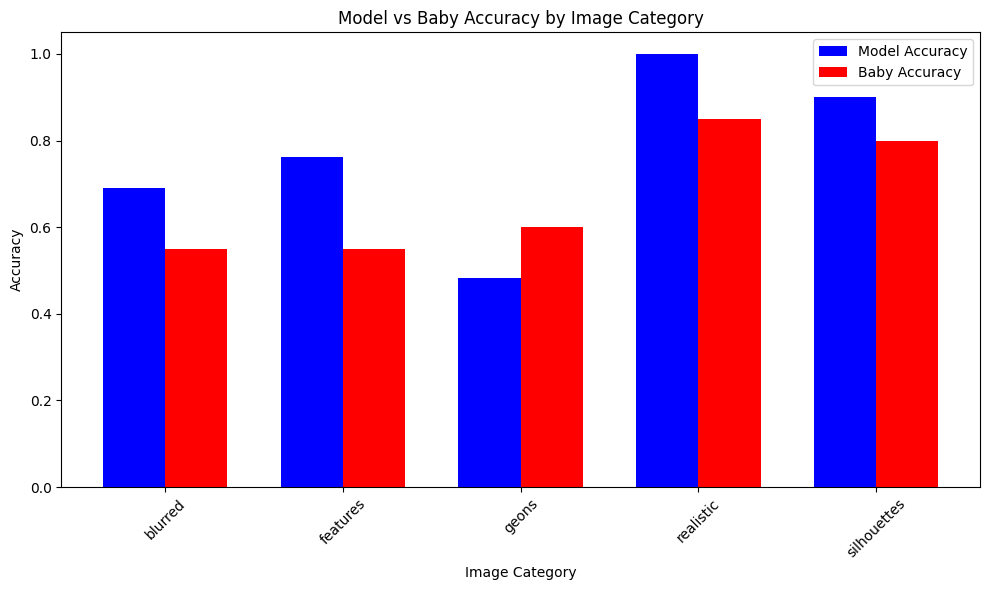

In [ ]:
import matplotlib.pyplot as plt


x = np.arange(len(accuracy_df))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x - width / 2, accuracy_df['Model_Accuracy'], width, label='Model Accuracy', color='b')
ax.bar(x + width / 2, accuracy_df['Baby_Accuracy'], width, label='Baby Accuracy', color='r')

ax.set_xlabel('Image Category')
ax.set_ylabel('Accuracy')
ax.set_title('Model vs Baby Accuracy by Image Category')
ax.set_xticks(x)
ax.set_xticklabels(accuracy_df['Image_Category'], rotation=45)
ax.legend()


plt.tight_layout()
plt.show()

In [ ]:
image_df['Images'][0]

'/content/extracted/datah4/blurred/Airplaneside_V3.jpg'

Q3)

The t-SNE visualization of the image embeddings from the final layer of the vision encoder displays the clustering of images in a 2D space. Similar images, such as objects of the same category for ex. airplanes, chairs, cups, are grouped closely together, reflecting the model's ability to encode visual features effectively.

Realistic and simplified conditions (like silhouettes and geons) are also organized into distinct regions, showing how the model differentiates between visual variations.

 This clustering highlights the model's capability to learn meaningful visual representations, preserving semantic relationships across different image categories and conditions.

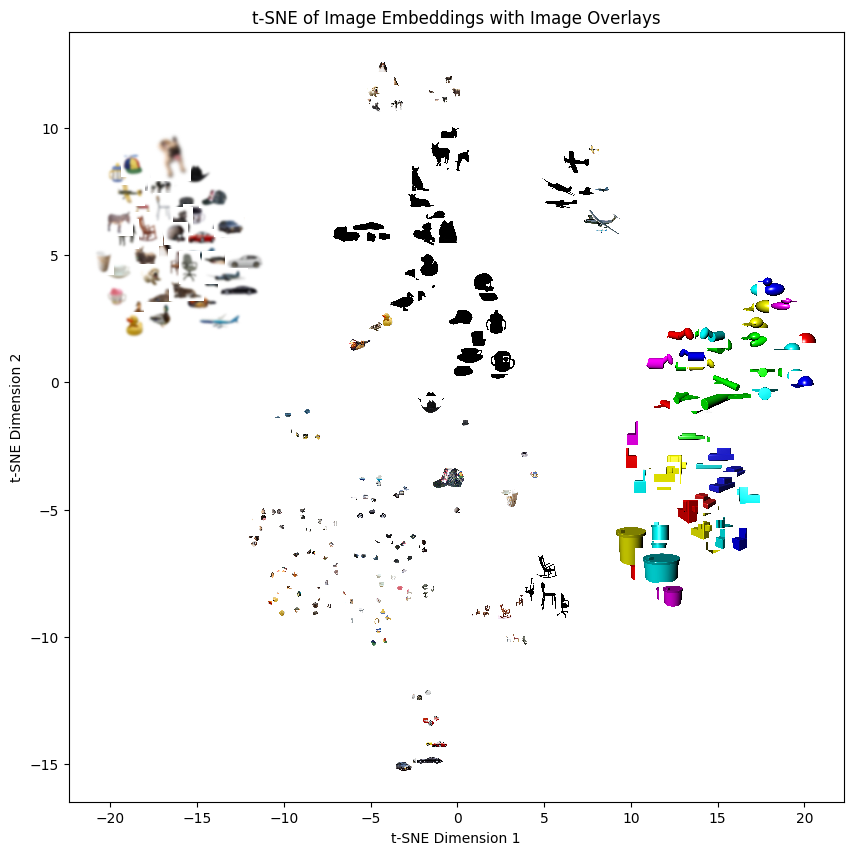

In [ ]:


image_paths = list(image_df["Images"])


def get_clip_embeddings(image_paths):
    embeddings = []
    for image_path in image_paths:
        image = Image.open(image_path).convert("RGB")
        inputs = processor(images=image, return_tensors="pt")
        with torch.no_grad():
            embedding = model.get_image_features(**inputs)
        embeddings.append(embedding.squeeze().cpu().numpy())

    return np.array(embeddings)


embeddings = get_clip_embeddings(image_paths)


tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(embeddings)


def plot_tsne_with_images(tsne_results, image_paths):
    fig, ax = plt.subplots(figsize=(10, 10))
    for i, (x, y) in enumerate(tsne_results):
        img = Image.open(image_paths[i])
        img = OffsetImage(img, zoom=0.01)
        ab = AnnotationBbox(img, (x, y), frameon=False)
        ax.add_artist(ab)
    ax.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0)
    ax.set_xlabel("t-SNE Dimension 1")
    ax.set_ylabel("t-SNE Dimension 2")
    ax.set_title("t-SNE of Image Embeddings with Image Overlays")
    plt.show()

plot_tsne_with_images(tsne_results, image_paths)